In [42]:
# =========================================================
# 1️⃣ Imports
# =========================================================
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    log_loss,
    roc_auc_score,
    f1_score,
    confusion_matrix
)

from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)

from sklearn.tree import DecisionTreeClassifier

from scipy.stats import randint, loguniform

import seaborn as sns
import matplotlib.pyplot as plt


In [43]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [44]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [45]:
# =========================================================
# 3️⃣ Feature Groups
# =========================================================
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [46]:
from sklearn.preprocessing import OneHotEncoder

# For scikit-learn >= 1.2
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # changed from sparse=False
ohe.fit(X_train[cat_cols])

X_train_cat = pd.DataFrame(
    ohe.transform(X_train[cat_cols]), 
    columns=ohe.get_feature_names_out(cat_cols)
)
X_test_cat = pd.DataFrame(
    ohe.transform(X_test[cat_cols]), 
    columns=ohe.get_feature_names_out(cat_cols)
)


In [47]:
# Combine numeric + encoded categorical
X_train_proc = pd.concat([X_train[num_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_proc  = pd.concat([X_test[num_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)


In [48]:
X_train_proc.shape

(7694, 180)

In [49]:
# Clean column names for LightGBM
X_train_proc.columns = X_train_proc.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)
X_test_proc.columns  = X_test_proc.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)


In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, log_loss, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =======================================
# Helper function for training & feature importance
# =======================================
def train_model_with_importance(model, param_grid, X_train, y_train, X_test, y_test, n_iter=20, cv=3, selected_features=[]):
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_log_loss',
        n_jobs=-1,
        random_state=42,
        verbose=1,
        refit=True
    )
    
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print(f"Best params: {search.best_params_}")
    
    # Predictions
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)
    
    # Metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'log_loss': log_loss(y_test, y_proba),
        'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted')
    }
    print("Metrics:", metrics)
    
    # # Confusion matrix
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(5,4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.show()

    
    
    # Feature importance
    if hasattr(best_model, 'feature_importances_'):
        fi = pd.Series(best_model.feature_importances_, index=X_train.columns)

        # Filter to only selected features
        fi = fi.loc[fi.index.intersection(selected_features)].sort_values(ascending=True)

        plt.figure(figsize=(10, max(4, len(fi)*0.6)))
        sns.barplot(x=fi.values, y=fi.index, palette='viridis')
        plt.title('Feature Importance (Selected Features)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()



    
    return best_model, metrics






# =======================================
# Random Forest
# =======================================
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}


# =======================================
# LightGBM
# =======================================
lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lgbm_params = {
    'n_estimators': [100, 300],         # fewer options
    'num_leaves': [31, 50],             # smaller set
    'learning_rate': [0.1, 0.2],        # reasonable rates
    'subsample': [0.8],                 # one choice
    'colsample_bytree': [0.8]           # one choice
}



/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20}
Metrics: {'accuracy': 0.8716216216216216, 'balanced_accuracy': 0.7547867500435599, 'log_loss': 0.3566821880606498, 'roc_auc': 0.9414811816010648, 'f1_weighted': 0.866492422185557}


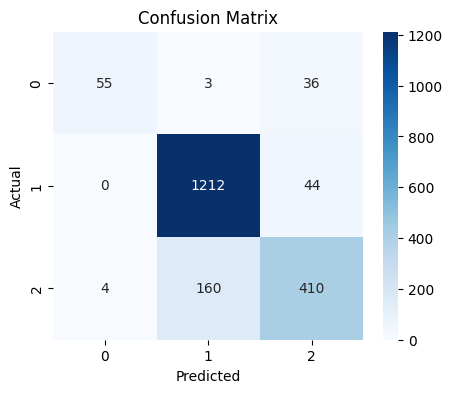

/tmp/ipykernel_1404760/2873814282.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


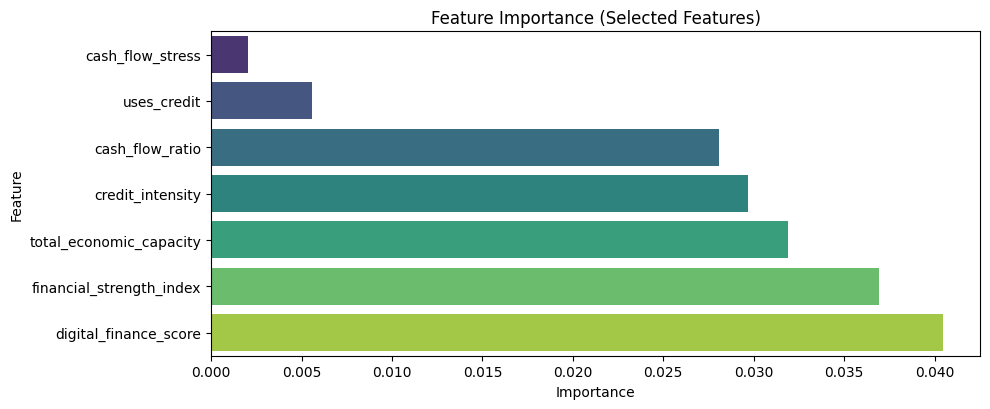

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 127
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 127
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] 

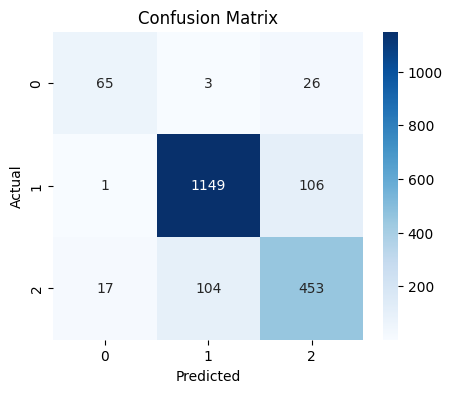

/tmp/ipykernel_1404760/2873814282.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


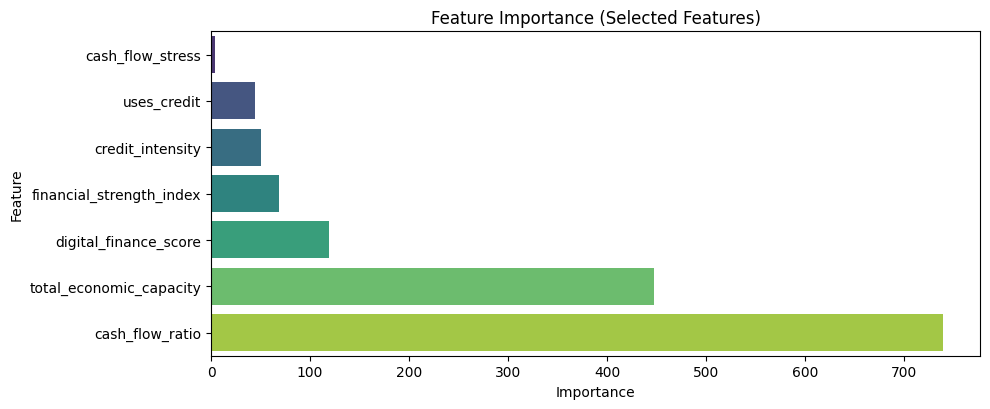

In [ ]:



selected_features = [
        'cash_flow_stress', 'uses_credit', 'digital_finance_score',
        'credit_intensity', 'financial_strength_index',
        'total_economic_capacity', 'cash_flow_ratio'
    ]
# =======================================
# Random Forest
# =======================================
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}


# =======================================
# LightGBM
# =======================================
lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lgbm_params = {
    'n_estimators': [100, 300],         # fewer options
    'num_leaves': [31, 50],             # smaller set
    'learning_rate': [0.1, 0.2],        # reasonable rates
    'subsample': [0.8],                 # one choice
    'colsample_bytree': [0.8]           # one choice
}



# V2

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20}
Metrics: {'accuracy': 0.8757796257796258, 'balanced_accuracy': 0.7623978899847467, 'log_loss': 0.3711008552028219, 'roc_auc': 0.941183198597182, 'f1_weighted': 0.8711174947441188}


/tmp/ipykernel_1473231/1771538275.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


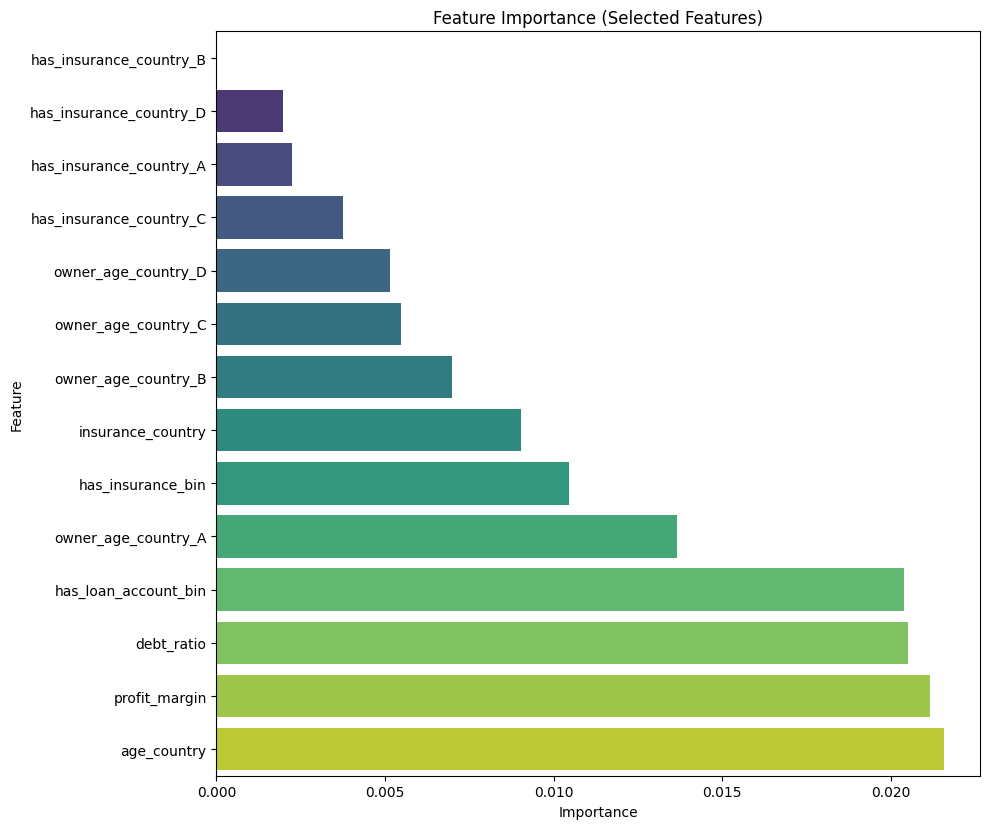

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Total Bins 2363
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 140
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] 

/tmp/ipykernel_1473231/1771538275.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


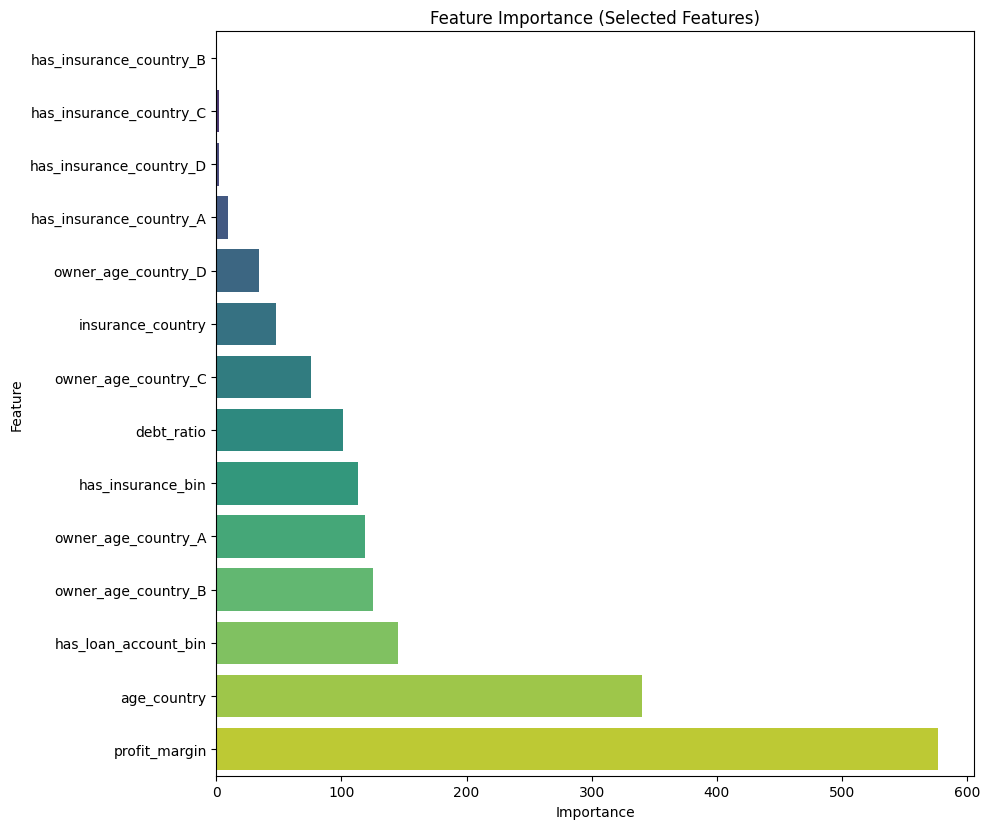

In [10]:
selected_features = [
    'owner_age_country_A', 'owner_age_country_B', 'owner_age_country_C', 'owner_age_country_D', 'has_loan_account_bin', 'age_country', 
    'has_insurance_bin', 'insurance_country', 'has_insurance_country_A', 'has_insurance_country_B', 'has_insurance_country_C', 'has_insurance_country_D',
    'profit_margin', 'debt_ratio'
]

rf_model, rf_metrics = train_model_with_importance(rf, rf_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc, selected_features=selected_features)
lgbm_model, lgbm_metrics = train_model_with_importance(lgbm, lgbm_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc,selected_features=selected_features)


# V3

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20}
Metrics: {'accuracy': 0.8659043659043659, 'balanced_accuracy': 0.7495327048744128, 'log_loss': 0.3414188156559116, 'roc_auc': 0.9428864163489176, 'f1_weighted': 0.8612818383716656}


/tmp/ipykernel_1662021/443689782.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


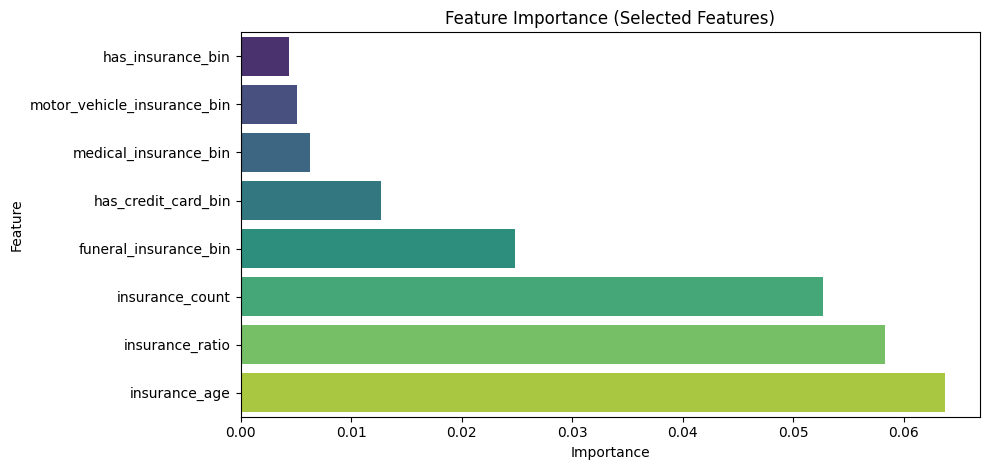

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2490
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 149
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2490
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 149
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] 

/tmp/ipykernel_1662021/443689782.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


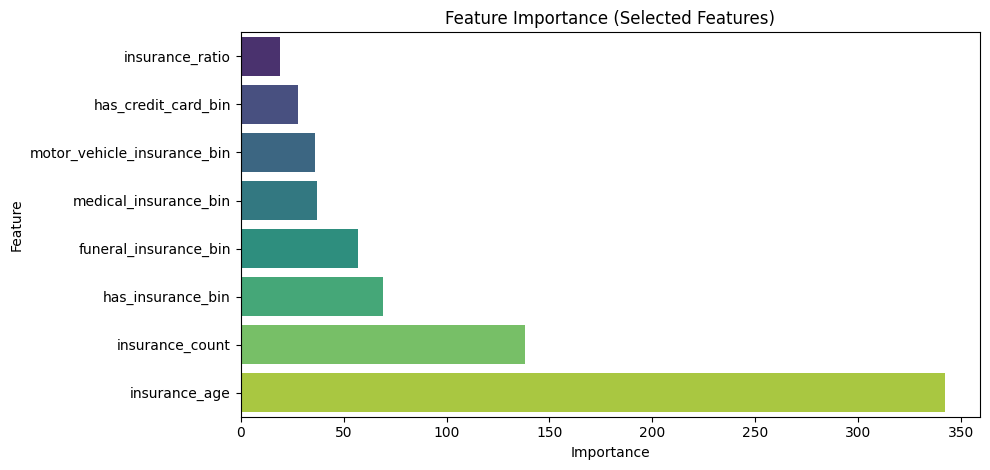

In [10]:
selected_features = [
'has_insurance_bin', 
'medical_insurance_bin', 
'funeral_insurance_bin', 
'motor_vehicle_insurance_bin',
'has_credit_card_bin','insurance_count', 'insurance_ratio', 'insurance_age'
]
rf_model, rf_metrics = train_model_with_importance(rf, rf_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc, selected_features=selected_features)
lgbm_model, lgbm_metrics = train_model_with_importance(lgbm, lgbm_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc,selected_features=selected_features)


# V4

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20}
Metrics: {'accuracy': 0.8700623700623701, 'balanced_accuracy': 0.7561978628808029, 'log_loss': 0.33727908319992395, 'roc_auc': 0.9430015481214311, 'f1_weighted': 0.8656421942764712}


/tmp/ipykernel_1662021/443689782.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


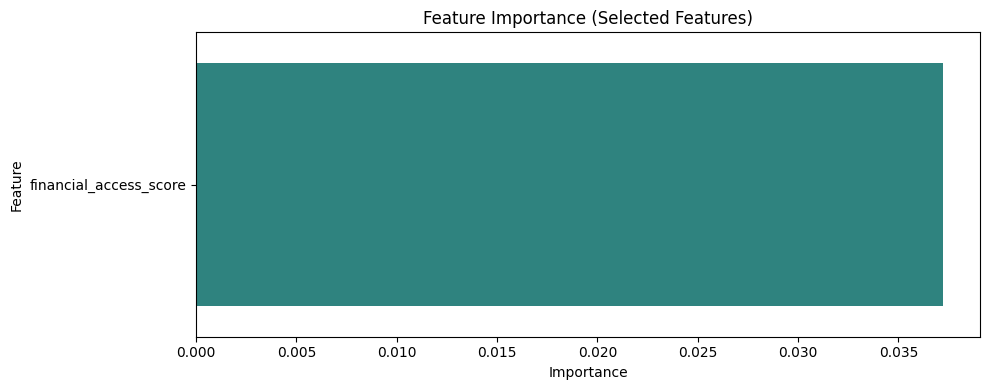

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2507
[LightGBM] [Info] Total Bins 2501
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 150
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start trai

/tmp/ipykernel_1662021/443689782.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


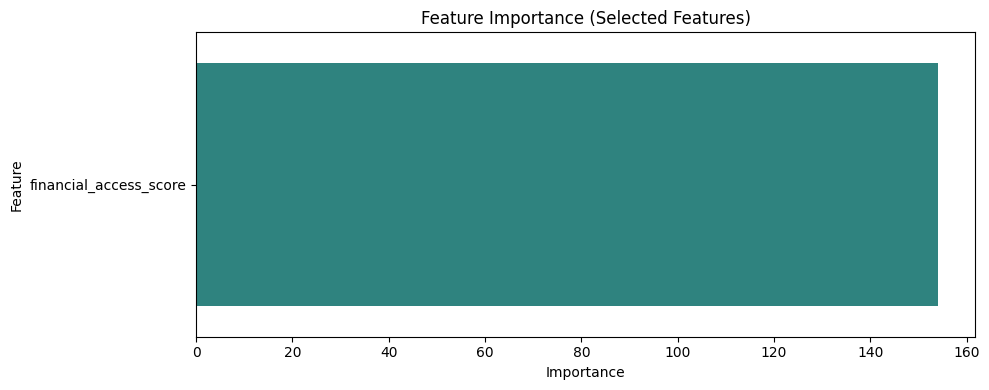

In [30]:
selected_features = ['financial_access_score']
rf_model, rf_metrics = train_model_with_importance(rf, rf_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc, selected_features=selected_features)
lgbm_model, lgbm_metrics = train_model_with_importance(lgbm, lgbm_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc,selected_features=selected_features)


# V5

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20}
Metrics: {'accuracy': 0.8711018711018711, 'balanced_accuracy': 0.7515559780643786, 'log_loss': 0.3328118483464107, 'roc_auc': 0.9439701791200025, 'f1_weighted': 0.8659303985383476}


/tmp/ipykernel_1662021/443689782.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


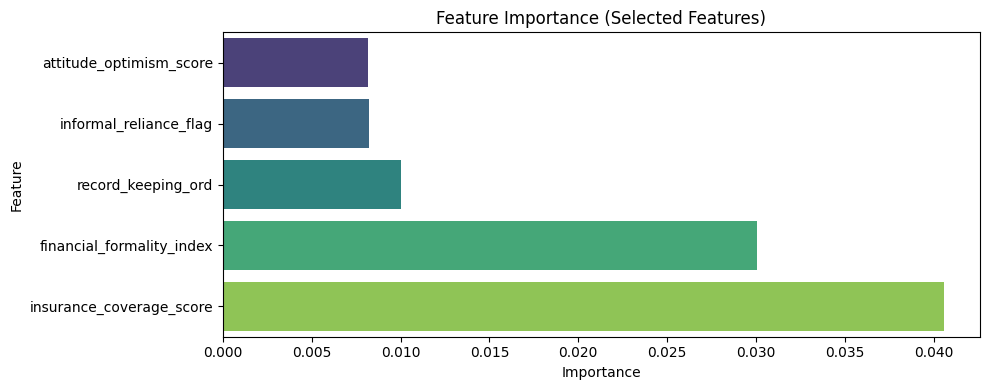

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2523
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 156
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 154
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start trai

/tmp/ipykernel_1662021/443689782.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


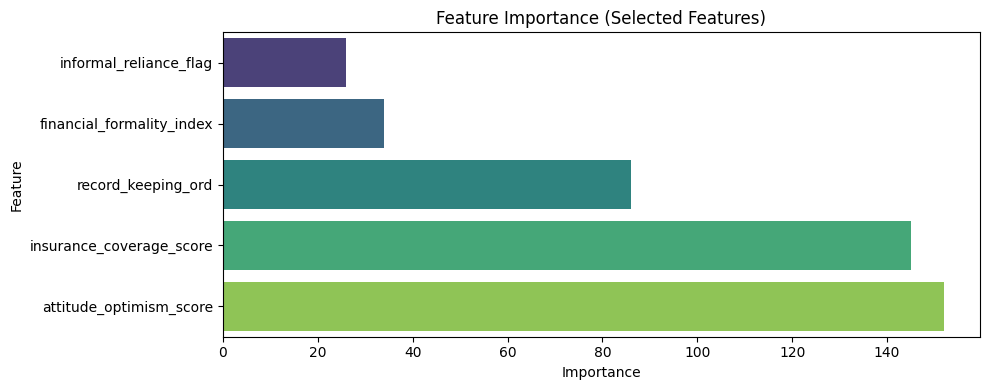

In [41]:
selected_features = ['record_keeping_ord', 'financial_formality_index', 'insurance_coverage_score', 'informal_reliance_flag', 'attitude_optimism_score']
rf_model, rf_metrics = train_model_with_importance(rf, rf_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc, selected_features=selected_features)
lgbm_model, lgbm_metrics = train_model_with_importance(lgbm, lgbm_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc,selected_features=selected_features)


# V6

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20}
Metrics: {'accuracy': 0.8685031185031185, 'balanced_accuracy': 0.7499136868461981, 'log_loss': 0.33314525703918224, 'roc_auc': 0.9438043396183674, 'f1_weighted': 0.8634279438467463}


/tmp/ipykernel_1662021/443689782.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


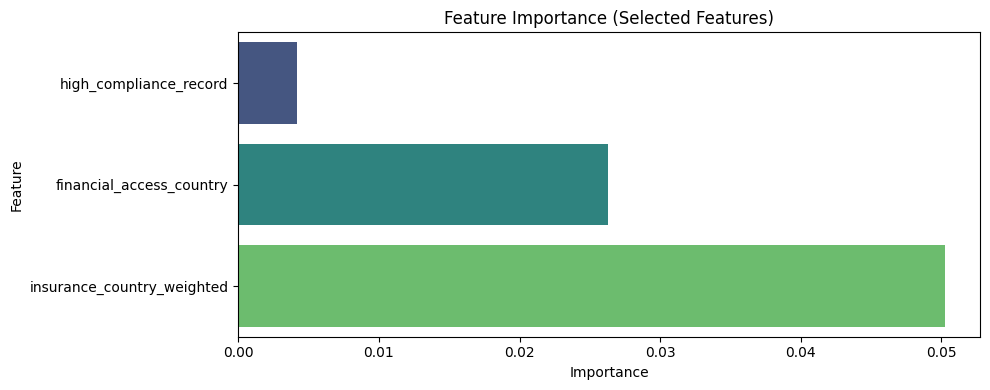

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 155
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 157
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] 

/tmp/ipykernel_1662021/443689782.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


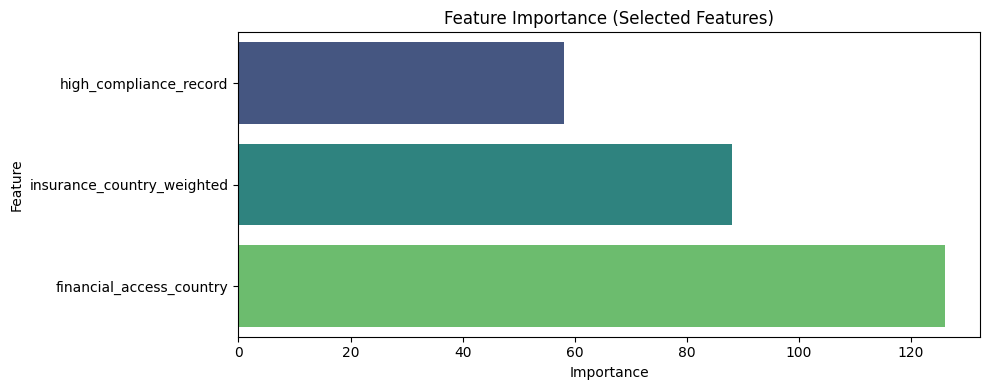

In [51]:
selected_features = [
        'financial_access_country',
    'high_compliance_record',
    'insurance_country_weighted',
]
rf_model, rf_metrics = train_model_with_importance(rf, rf_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc, selected_features=selected_features)
lgbm_model, lgbm_metrics = train_model_with_importance(lgbm, lgbm_params, X_train_proc, y_train_enc, X_test_proc, y_test_enc,selected_features=selected_features)


In [5]:
target_encode_cols = ['funeral_insurance', 'medical_insurance', 
            'motor_vehicle_insurance', 'has_credit_card', 'keeps_financial_records']  # replace with your chosen cols
onehot_cols = [c for c in cat_cols if c not in target_encode_cols]


In [6]:
missing_cols = [c for c in cat_cols if c not in target_encode_cols]
print("Missing cols:", missing_cols)


Missing cols: ['country', 'attitude_stable_business_environment', 'attitude_worried_shutdown', 'compliance_income_tax', 'perception_insurance_doesnt_cover_losses', 'perception_cannot_afford_insurance', 'has_mobile_money', 'current_problem_cash_flow', 'has_cellphone', 'owner_sex', 'offers_credit_to_customers', 'attitude_satisfied_with_achievement', 'perception_insurance_companies_dont_insure_businesses_like_yours', 'perception_insurance_important', 'has_insurance', 'covid_essential_service', 'attitude_more_successful_next_year', 'problem_sourcing_money', 'marketing_word_of_mouth', 'has_loan_account', 'has_internet_banking', 'has_debit_card', 'future_risk_theft_stock', 'motivation_make_more_money', 'uses_friends_family_savings', 'uses_informal_lender']


- try again 'JamesSteinEncoder'

In [ ]:
import category_encoders as ce

# =========================================================
# 4️⃣ Tree-Optimized Preprocessing
# =========================================================
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])


target_encode_cols = ['funeral_insurance', 'medical_insurance', 
            'motor_vehicle_insurance', 'has_credit_card', 'keeps_financial_records']  # replace with your chosen cols
onehot_cols = [c for c in cat_cols if c not in target_encode_cols]



# Target encoding pipeline
target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', ce.CatBoostEncoder()) 
])


# One-hot encoding pipeline
onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('target', target_pipeline, target_encode_cols),
        ('onehot', onehot_pipeline, onehot_cols)
    ],
    remainder='drop'
)


In [90]:
# =========================================================
# 5️⃣ Pipeline Builder
# =========================================================
def build_pipeline(model):
    return Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])


In [91]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# =========================================================
# 6️⃣ Tree Models + Hyperparameters (FAST ITERATION)
# =========================================================
models = {

    # 🌲 Random Forest
    'random_forest': {
        'model': RandomForestClassifier(
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__n_estimators': [100, 300, 500],
            'model__max_depth': [None, 10, 20],
            'model__max_features': ['sqrt', 'log2']
        }
    },

    # 🌲 Extra Trees
    'extra_trees': {
        'model': ExtraTreesClassifier(
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__n_estimators': [100, 300, 500],
            'model__max_depth': [None, 10, 20],
            'model__max_features': ['sqrt', 'log2']
        }
    },

    # 🌲 Gradient Boosting
    'gradient_boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 300, 500],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5],
            'model__subsample': [0.8, 1.0]
        }
    },

    # 🌲 AdaBoost
    'adaboost': {
        'model': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            random_state=42
        ),
        'params': {
            'model__n_estimators': [50, 150, 300],
            'model__learning_rate': [0.05, 0.1, 0.2]
        }
    },

    # 🌲 XGBoost
    'xgboost': {
        'model': XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=-1
        ),
        'params': {
            'model__n_estimators': [100, 300, 500],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
    },

    # 🌲 LightGBM
    'lightgbm': {
        'model': LGBMClassifier(
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__n_estimators': [100, 300, 500],
            'model__num_leaves': [31, 50, 70],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
    },

    # 🌲 Logistic Regression
    'logistic_regression': {
        'model': LogisticRegression(
            random_state=42,
            max_iter=1000,
            class_weight='balanced',
            n_jobs=-1
        ),
        'params': {
            'model__C': [0.01, 0.1, 1, 10],   # regularization strength
            'model__penalty': ['l2'],         # keep simple for fast iteration
            'model__solver': ['lbfgs']        # compatible with l2
        }
    }
}


In [92]:
# =========================================================
# 7️⃣ Training & Evaluation Function
# =========================================================
def train_and_evaluate(
    X_train, y_train,
    X_test, y_test,
    model_dict,
    n_iter=30,
    cv=5,
    plot_confusion=True
):

    results = {}
    summary = []

    for name, cfg in model_dict.items():
        print(f"\n{'='*20} {name.upper()} {'='*20}")

        pipe = build_pipeline(cfg['model'])

        search = RandomizedSearchCV(
            pipe,
            param_distributions=cfg['params'],
            n_iter=n_iter,
            cv=cv,
            scoring='neg_log_loss',
            n_jobs=14,
            verbose=1,
            random_state=42,
            refit=True
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'log_loss': log_loss(y_test, y_proba),
            'roc_auc': roc_auc_score(
                y_test, y_proba,
                multi_class='ovr',
                average='weighted'
            ),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted')
        }

        cm = confusion_matrix(y_test, y_pred)

        results[name] = {
            'best_model': best_model,
            'best_params': search.best_params_,
            'cv_score': search.best_score_,
            'metrics': metrics,
            'confusion_matrix': cm
        }

        summary.append({
            'Model': name,
            **metrics,
            'CV Score': search.best_score_
        })

        print("Best Params:", search.best_params_)
        print("Metrics:", metrics)

        if plot_confusion:
            plt.figure(figsize=(6,5))
            sns.heatmap(
                cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_
            )
            plt.title(f'Confusion Matrix - {name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

    summary_df = pd.DataFrame(summary).sort_values('roc_auc', ascending=False)
    display(summary_df)

    return results, summary_df


In [93]:
import os
os.cpu_count()

16


==================== RANDOM_FOREST ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits


Best Params: {'model__n_estimators': 500, 'model__max_features': 'sqrt', 'model__max_depth': None}
Metrics: {'accuracy': 0.8591476091476091, 'balanced_accuracy': 0.7281694024808137, 'log_loss': 0.3896290701626226, 'roc_auc': 0.9345243339990321, 'f1_weighted': 0.8511374187068407}


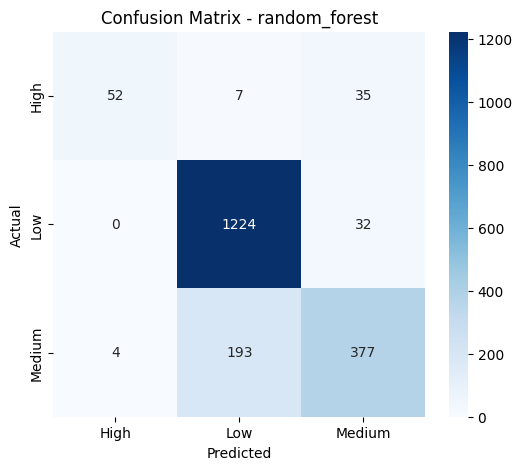


==================== EXTRA_TREES ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'model__n_estimators': 500, 'model__max_features': 'sqrt', 'model__max_depth': None}
Metrics: {'accuracy': 0.8508316008316008, 'balanced_accuracy': 0.7137656711397616, 'log_loss': 0.42963701524555004, 'roc_auc': 0.923453052957814, 'f1_weighted': 0.8428619524943607}


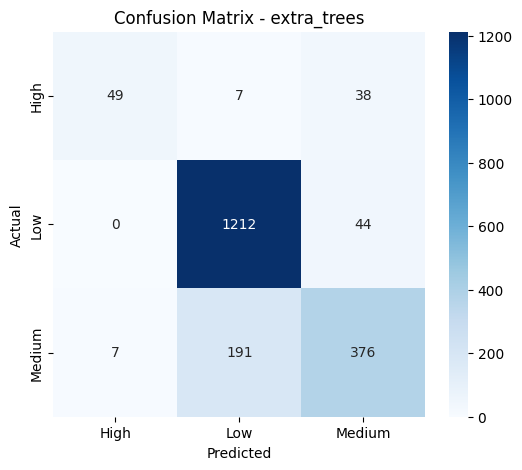


==================== GRADIENT_BOOSTING ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'model__subsample': 1.0, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1}
Metrics: {'accuracy': 0.8721413721413721, 'balanced_accuracy': 0.7512077545610412, 'log_loss': 0.33201167946056054, 'roc_auc': 0.9370814248659788, 'f1_weighted': 0.8640017950760951}


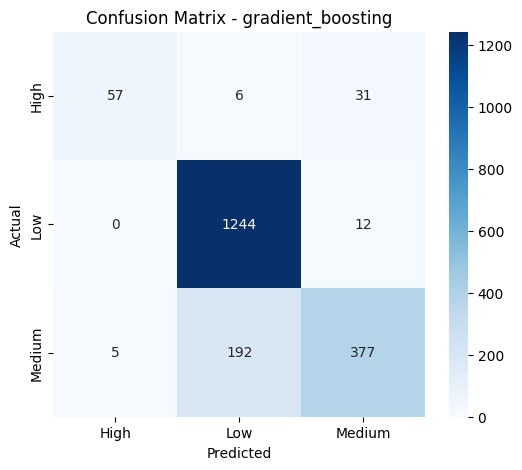


==================== ADABOOST ====================
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=15. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'model__n_estimators': 50, 'model__learning_rate': 0.05}
Metrics: {'accuracy': 0.7806652806652806, 'balanced_accuracy': 0.4761904761904762, 'log_loss': 0.8802385379130103, 'roc_auc': 0.7223184481307579, 'f1_weighted': 0.7374306041815539}


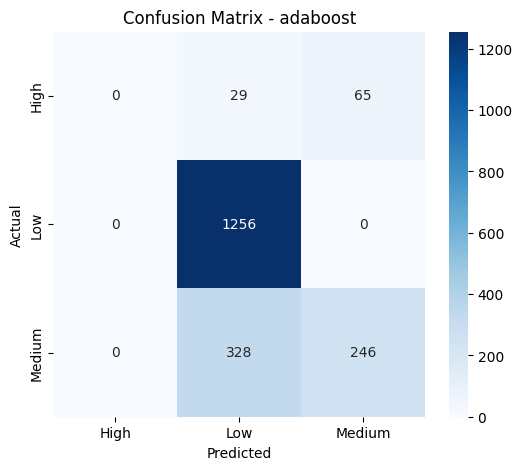


==================== XGBOOST ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:40:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:40:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:40:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:40:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packag

Best Params: {'model__subsample': 0.8, 'model__n_estimators': 500, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Metrics: {'accuracy': 0.8731808731808732, 'balanced_accuracy': 0.7581725197491264, 'log_loss': 0.3184991759834166, 'roc_auc': 0.9399534140652723, 'f1_weighted': 0.866150893365315}


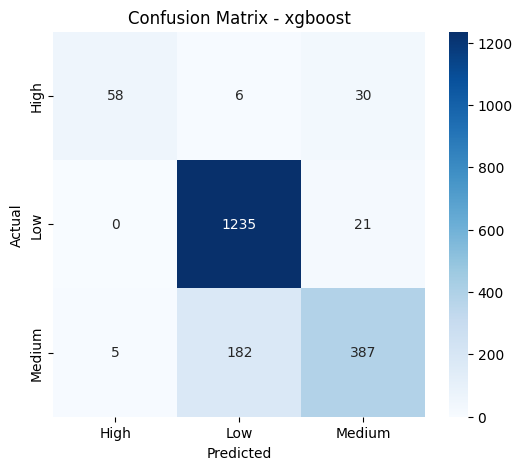


==================== LIGHTGBM ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Number of data points in the train set: 

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start 

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further sp

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You ca

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start 

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 7694, number of used features: 104
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best Params: {'model__subsample': 0.8, 'model__num_leaves': 70, 'model__n_estimators': 100, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Metrics: {'accuracy': 0.8575883575883576, 'balanced_accuracy': 0.7806765644854288, 'log_loss': 0.32821431596163064, 'roc_auc': 0.9395204809433727, 'f1_weighted': 0.8571754832231023}


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


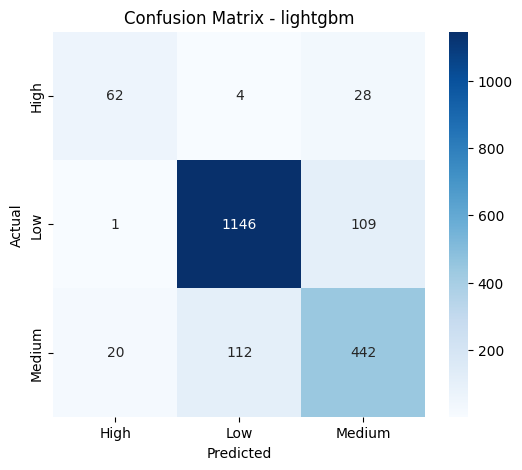

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=15. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



==================== LOGISTIC_REGRESSION ====================
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stab

Best Params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 0.01}
Metrics: {'accuracy': 0.47505197505197505, 'balanced_accuracy': 0.5326338682191151, 'log_loss': 1.0322403087349177, 'roc_auc': 0.6278449023511358, 'f1_weighted': 0.5223533392196327}


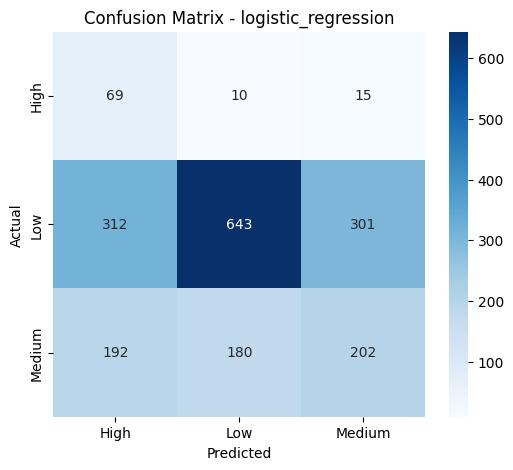

,Model,accuracy,balanced_accuracy,log_loss,roc_auc,f1_weighted,CV Score
4,xgboost,0.873181,0.758173,0.318499,0.939953,0.866151,-0.323730
5,lightgbm,0.857588,0.780677,0.328214,0.939520,0.857175,-0.334217
2,gradient_boosting,0.872141,0.751208,0.332012,0.937081,0.864002,-0.332103
0,random_forest,0.859148,0.728169,0.389629,0.934524,0.851137,-0.391106
1,extra_trees,0.850832,0.713766,0.429637,0.923453,0.842862,-0.417669
3,adaboost,0.780665,0.476190,0.880239,0.722318,0.737431,-0.876055
6,logistic_regression,0.475052,0.532634,1.032240,0.627845,0.522353,-0.990034


Execution time: 351.73 seconds


In [94]:

import time

start_time = time.time()  # start timer

# =========================================================
# 8️⃣ RUN EVERYTHING
# =========================================================
results_tree, summary_tree = train_and_evaluate(
    X_train,
    y_train_enc,
    X_test,
    y_test_enc,
    models,
    n_iter=15,
    cv=3
)

end_time = time.time()  # end timer

print(f"Execution time: {end_time - start_time:.2f} seconds")



==================== RANDOM_FOREST ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'model__n_estimators': 500, 'model__max_features': 'sqrt', 'model__max_depth': None}
Metrics: {'accuracy': 0.8716216216216216, 'balanced_accuracy': 0.7434954273506493, 'log_loss': 0.3695994367075118, 'roc_auc': 0.942750425535593, 'f1_weighted': 0.864780402484442}


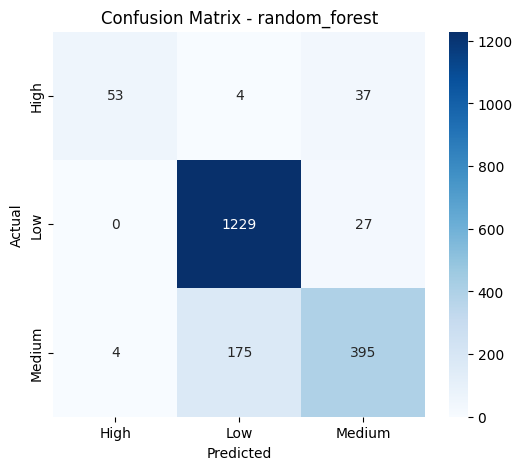


==================== EXTRA_TREES ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'model__n_estimators': 300, 'model__max_features': 'sqrt', 'model__max_depth': 20}
Metrics: {'accuracy': 0.8690228690228691, 'balanced_accuracy': 0.7631744722718944, 'log_loss': 0.36724609929142993, 'roc_auc': 0.9410800163114387, 'f1_weighted': 0.8652032016473526}


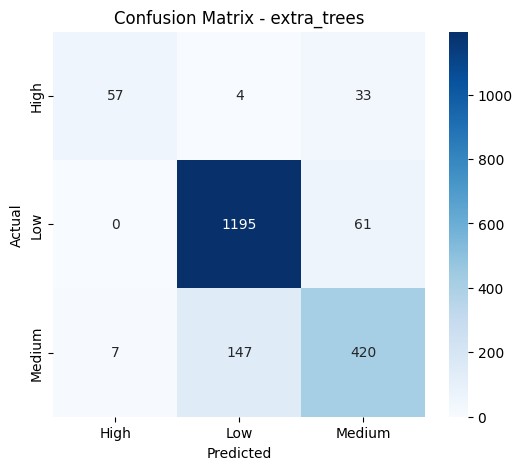


==================== GRADIENT_BOOSTING ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1}
Metrics: {'accuracy': 0.8752598752598753, 'balanced_accuracy': 0.7565840389881258, 'log_loss': 0.3171006051027241, 'roc_auc': 0.9426796261681408, 'f1_weighted': 0.8681705337434381}


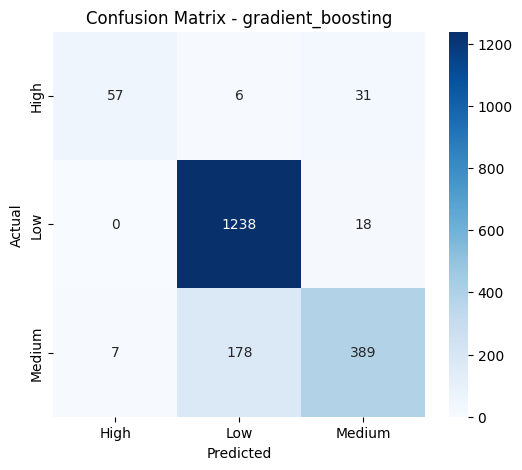


==================== ADABOOST ====================
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=15. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'model__n_estimators': 50, 'model__learning_rate': 0.05}
Metrics: {'accuracy': 0.7806652806652806, 'balanced_accuracy': 0.4761904761904762, 'log_loss': 0.8801518582095594, 'roc_auc': 0.7223184481307579, 'f1_weighted': 0.7374306041815539}


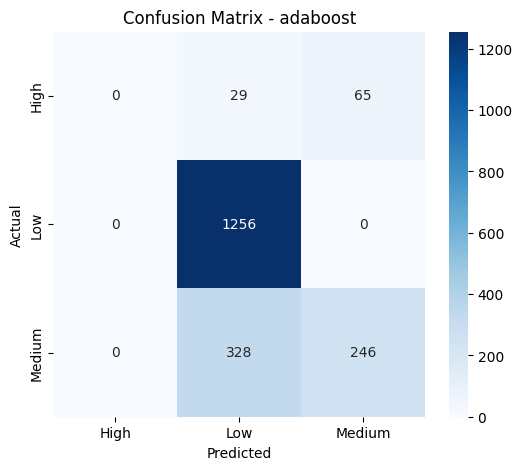


==================== XGBOOST ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:15:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:15:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:15:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:15:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packag

Best Params: {'model__subsample': 0.8, 'model__n_estimators': 500, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Metrics: {'accuracy': 0.8762993762993763, 'balanced_accuracy': 0.7560414092224867, 'log_loss': 0.3104161286764068, 'roc_auc': 0.9437475510222638, 'f1_weighted': 0.8696961544020367}


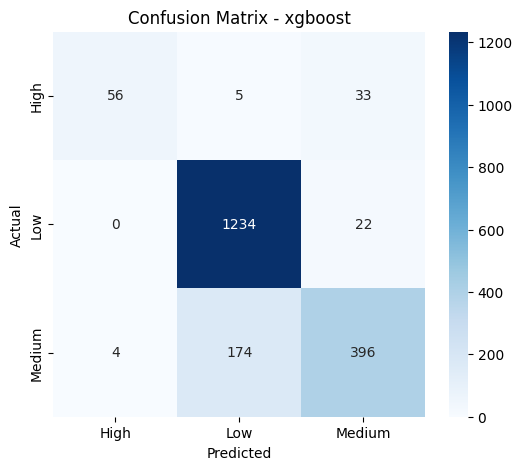


==================== LIGHTGBM ====================
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 120
[LightGBM] [Info] Auto-choosing row-wise multi-t

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005287 sec

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 120
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 120
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[L

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 120
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 120
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 120
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 120
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 5129, number of used features: 120
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 5130, number of used features: 122
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 7694, number of used features: 123
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best Params: {'model__subsample': 0.8, 'model__num_leaves': 70, 'model__n_estimators': 100, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Metrics: {'accuracy': 0.8591476091476091, 'balanced_accuracy': 0.7925761716041647, 'log_loss': 0.3173372537183419, 'roc_auc': 0.9433478042570513, 'f1_weighted': 0.8590230464642146}


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


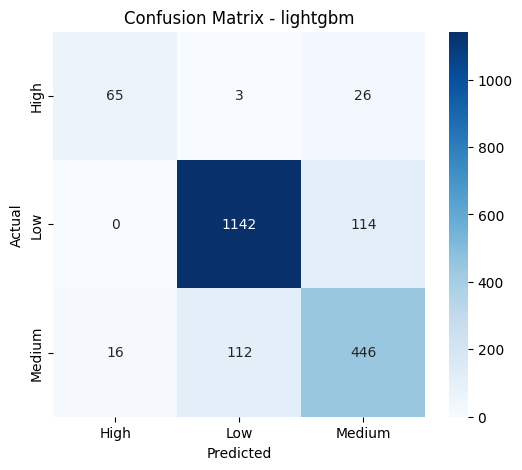

/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=15. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



==================== LOGISTIC_REGRESSION ====================
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ismail/miniconda/envs/ml-dl/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stab

Best Params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 0.1}
Metrics: {'accuracy': 0.5415800415800416, 'balanced_accuracy': 0.5815519612662295, 'log_loss': 0.960585217687468, 'roc_auc': 0.6806182717478977, 'f1_weighted': 0.5875955673130291}


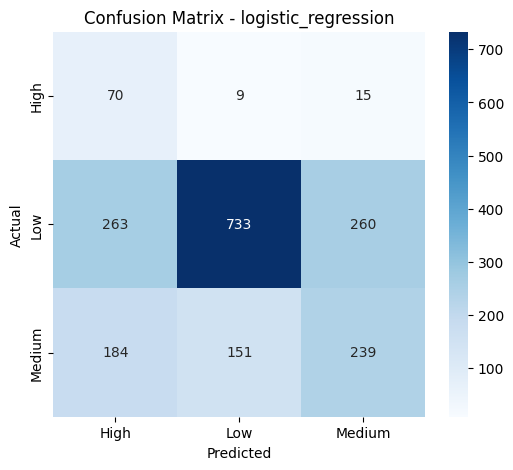

,Model,accuracy,balanced_accuracy,log_loss,roc_auc,f1_weighted,CV Score
4,xgboost,0.876299,0.756041,0.310416,0.943748,0.869696,-0.312036
5,lightgbm,0.859148,0.792576,0.317337,0.943348,0.859023,-0.328372
0,random_forest,0.871622,0.743495,0.369599,0.942750,0.864780,-0.358807
2,gradient_boosting,0.875260,0.756584,0.317101,0.942680,0.868171,-0.317779
1,extra_trees,0.869023,0.763174,0.367246,0.941080,0.865203,-0.357091
3,adaboost,0.780665,0.476190,0.880152,0.722318,0.737431,-0.875947
6,logistic_regression,0.541580,0.581552,0.960585,0.680618,0.587596,-0.937271


Execution time: 270.85 seconds


In [15]:

import time

start_time = time.time()  # start timer

# =========================================================
# 8️⃣ RUN EVERYTHING
# =========================================================
results_tree, summary_tree = train_and_evaluate(
    X_train,
    y_train_enc,
    X_test,
    y_test_enc,
    models,
    n_iter=15,
    cv=3
)

end_time = time.time()  # end timer

print(f"Execution time: {end_time - start_time:.2f} seconds")



==================== RANDOM_FOREST ====================
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best Params: {'model__max_depth': 20, 'model__max_features': None, 'model__min_samples_leaf': 3, 'model__min_samples_split': 13, 'model__n_estimators': 866}
Metrics: {'accuracy': 0.8653846153846154, 'balanced_accuracy': 0.7938084605857191, 'log_loss': 0.3479778447374147, 'roc_auc': 0.9390385829494499, 'f1_weighted': 0.8629296937765346}


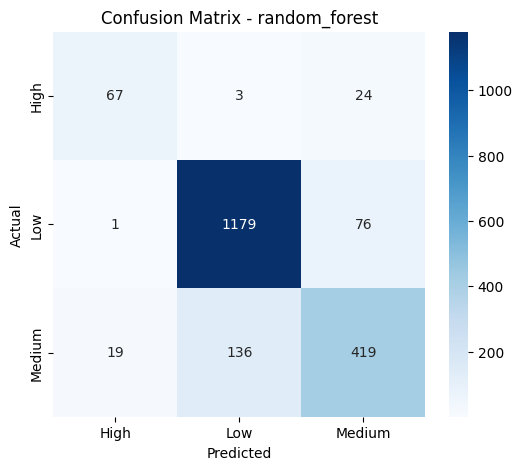


==================== EXTRA_TREES ====================
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'model__max_depth': 40, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 13, 'model__n_estimators': 613}
Metrics: {'accuracy': 0.8565488565488566, 'balanced_accuracy': 0.7980654875034608, 'log_loss': 0.3778414741302029, 'roc_auc': 0.9416067618426015, 'f1_weighted': 0.8560466599015242}


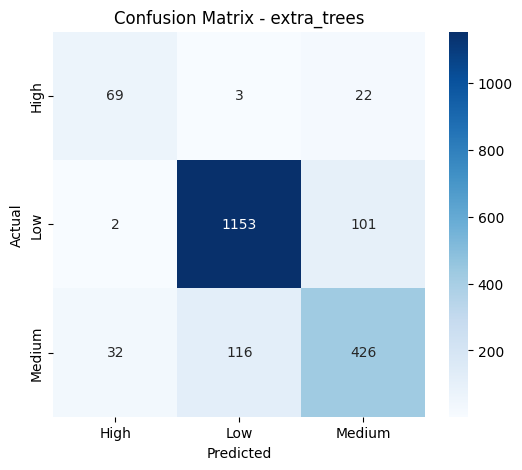


==================== GRADIENT_BOOSTING ====================
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'model__learning_rate': 0.014581398811193668, 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__n_estimators': 790, 'model__subsample': 1.0}
Metrics: {'accuracy': 0.8804573804573804, 'balanced_accuracy': 0.7689526529362055, 'log_loss': 0.30501109640126617, 'roc_auc': 0.946237277158304, 'f1_weighted': 0.8742838298769577}


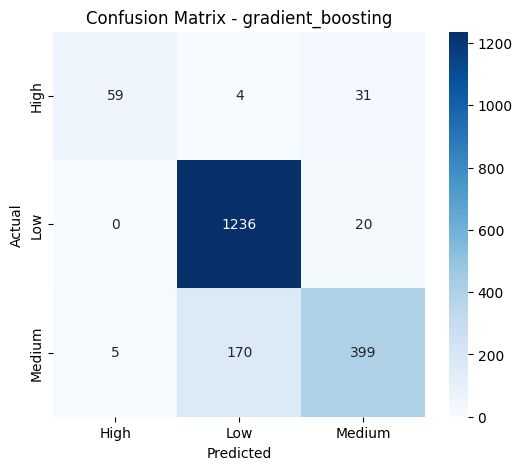


==================== ADABOOST ====================
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'model__estimator__max_depth': 1, 'model__learning_rate': 0.012385137298860928, 'model__n_estimators': 70}
Metrics: {'accuracy': 0.7806652806652806, 'balanced_accuracy': 0.4761904761904762, 'log_loss': 0.829625786323948, 'roc_auc': 0.7223184481307579, 'f1_weighted': 0.7374306041815539}


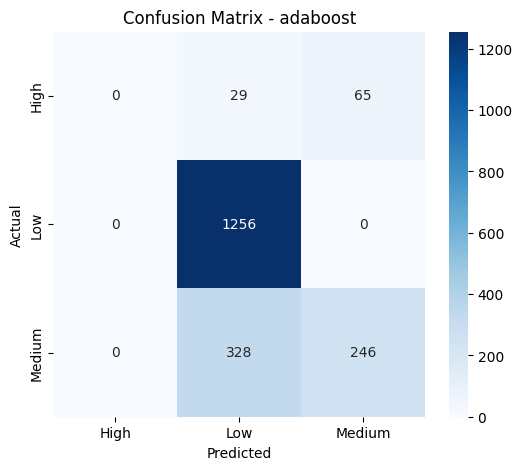

,Model,accuracy,balanced_accuracy,log_loss,roc_auc,f1_weighted,CV Score
2,gradient_boosting,0.880457,0.768953,0.305011,0.946237,0.874284,-0.304960
1,extra_trees,0.856549,0.798065,0.377841,0.941607,0.856047,-0.367771
0,random_forest,0.865385,0.793808,0.347978,0.939039,0.862930,-0.338442
3,adaboost,0.780665,0.476190,0.829626,0.722318,0.737431,-0.823821


In [41]:
# =========================================================
# 8️⃣ RUN EVERYTHING
# =========================================================
results_tree, summary_tree = train_and_evaluate(
    X_train,
    y_train_enc,
    X_test,
    y_test_enc,
    models,
    n_iter=30,
    cv=5
)


In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# =========================================================
# 6️⃣ Tree Models + Hyperparameters
# =========================================================
models = {

    # 🌲 Random Forest
    'random_forest': {
        'model': RandomForestClassifier(
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__n_estimators': randint(300, 1200),
            'model__max_depth': [None, 10, 20, 40],
            'model__min_samples_split': randint(2, 20),
            'model__min_samples_leaf': randint(1, 10),
            'model__max_features': ['sqrt', 'log2', None]
        }
    },

    # 🌲 Extra Trees (STRONG BASELINE)
    'extra_trees': {
        'model': ExtraTreesClassifier(
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__n_estimators': randint(300, 1200),
            'model__max_depth': [None, 10, 20, 40],
            'model__min_samples_split': randint(2, 20),
            'model__min_samples_leaf': randint(1, 10),
            'model__max_features': ['sqrt', 'log2', None]
        }
    },

    # 🌲 Gradient Boosting
    'gradient_boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': randint(100, 800),
            'model__learning_rate': loguniform(0.01, 0.3),
            'model__max_depth': randint(3, 8),
            'model__subsample': [0.6, 0.8, 1.0],
            'model__max_features': ['sqrt', 'log2', None]
        }
    },

    # 🌲 AdaBoost
    'adaboost': {
        'model': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            random_state=42
        ),
        'params': {
            'model__n_estimators': randint(50, 600),
            'model__learning_rate': loguniform(0.01, 1.0),
            'model__estimator__max_depth': [1, 2, 3]
        }
    },

    # 🌲 XGBoost
    'xgboost': {
        'model': XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=-1
        ),
        'params': {
            'model__n_estimators': randint(100, 1000),
            'model__max_depth': randint(3, 10),
            'model__learning_rate': loguniform(0.01, 0.3),
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0],
            'model__gamma': [0, 0.1, 0.2, 0.5]
        }
    },

    # 🌲 LightGBM
    'lightgbm': {
        'model': LGBMClassifier(
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__n_estimators': randint(100, 1000),
            'model__num_leaves': randint(20, 150),
            'model__learning_rate': loguniform(0.01, 0.3),
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0],
            'model__reg_alpha': [0, 0.01, 0.1, 1],
            'model__reg_lambda': [0, 0.01, 0.1, 1]
        }
    }
}
